In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error
import pickle
from math import sqrt
from sklearn.metrics import r2_score
import seaborn as sns
from xgboost import XGBRegressor

# Data preprocessing function
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(['ProductName', 'SourceName', 'DestinationName','MaxTonnage'], axis=1)
    
    # Handle missing values
    df = df.dropna()

    # Drop outliers
    df = df[(df['Fee'] >= df['MinFee']) & (df['Fee'] <= 29000000) & (df['Fee'] >= 300000) & (df['Tonnage'] >= 8) & (df['Fee'] <= 5 * df['MinFee'])]
    min_count_threshold = 10
    df= df[df.groupby('ProductId')['ProductId'].transform('count') >= min_count_threshold]
    df = df[df.groupby('SourceId')['SourceId'].transform('count') >= min_count_threshold]
    df = df[df.groupby('DestinationId')['DestinationId'].transform('count') >= min_count_threshold]
    # Extract year, month, day, hour, and minute from the datetime column
    df['year'] = df['CreatedDateTime'].dt.year
    df['month'] = df['CreatedDateTime'].dt.month
    df['day'] = df['CreatedDateTime'].dt.day
    df['hour'] = df['CreatedDateTime'].dt.hour
    df['minute'] = df['CreatedDateTime'].dt.minute
    
    # Drop the original datetime column
    df = df.drop(['CreatedDateTime'], axis=1)

    # Remove data for the year 2022
    df = df[df['year'] != 2022]

    # Remove duplicates
    df = df.drop_duplicates()
    df = df.drop(['MinFee'], axis=1)
    print(df.shape)
    return df

def replace_outliers_with_mean(df):
    # Define the conditions for grouping
    group_cols = ['ProductId', 'SourceId', 'DestinationId', 'Tonnage']
    
    # Get unique groups based on the specified columns
    unique_groups = df[group_cols].drop_duplicates()
    
    # Iterate over unique groups
    for _, group in unique_groups.iterrows():
        # Filter DataFrame based on the current group
        mask = (df['ProductId'] == group['ProductId']) & \
               (df['SourceId'] == group['SourceId']) & \
               (df['DestinationId'] == group['DestinationId']) & \
               (df['Tonnage'] == group['Tonnage'])
        
        group_df = df[mask]
        
        # Calculate mean of 'Fee' column within the group
        mean_fee = group_df['Fee'].mean().astype(int).astype(int)
       # mean_min_fee = group_df['MinFee'].mean().astype(int)
        # Replace outliers in 'Fee' column within the group with the mean
        df.loc[mask & (df['Fee'] > mean_fee), 'Fee'] = mean_fee
        """ df.loc[mask & (df['MinFee'] > mean_min_fee), 'MinFee'] = mean_min_fee
        df = df[df['Fee'] >= df['MinFee']]"""
        df.reset_index(drop=True, inplace=True)
        
    return df

# Train-test split function
def split_data(df, n_splits=5, random_state=42):
    X = df.drop(columns=['Fee'], axis=1)
    y = df['Fee']

    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        yield X_train, X_test, y_train, y_test

# Evaluate model function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print('RMSE:', rmse)
    print('R-squared:', r2)

# Save model function
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Define a function to plot residual plots
def plot_residuals(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate residuals
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test
    
    # Plot residuals
    plt.figure(figsize=(10, 5))
    
    # Train set residuals
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred_train, residuals_train, alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot - Train Set')
    
    # Test set residuals
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_test, residuals_test, alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot - Test Set')
    
    plt.tight_layout()
    plt.show()


In [2]:
# Load data from the database
df = pd.read_excel("CargoesAI.xlsx")

# Data preprocessing
df = preprocess_data(df)
df = replace_outliers_with_mean(df)
df = df.dropna()

(35289, 10)


In [15]:
# Define models and parameters for GridSearchCV
models = {
    'RandomForest': RandomForestRegressor(),
    'ExtraTrees': ExtraTreesRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor() 
}

param_grids = {
    'RandomForest': {'model__n_estimators': [50, 100, 200]},
    'ExtraTrees': {'model__n_estimators': [50, 100, 200]},
    'GradientBoosting': {'model__n_estimators': [50, 100, 200]},
    'XGBoost': {'model__n_estimators': [50, 100, 200]}
}

best_model = None
best_rmse = float('inf')

for model_name, model in models.items():
    pipeline = Pipeline([
        ('model', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grids[model_name], scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1)
    
    # Use the modified split_data function for k-fold cross-validation
    for X_train, X_test, y_train, y_test in split_data(df):
        grid_search.fit(X_train, y_train)

        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        y_pred = grid_search.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE for {model_name}: {rmse}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = grid_search.best_estimator_

# Evaluate the best model
evaluate_model(best_model, X_test, y_test)

# Save the best model
save_model(best_model, 'best_model.pkl')


Best parameters for RandomForest: {'model__n_estimators': 200}
RMSE for RandomForest: 610195.7193929586
Best parameters for RandomForest: {'model__n_estimators': 200}
RMSE for RandomForest: 624379.948135937
Best parameters for RandomForest: {'model__n_estimators': 200}
RMSE for RandomForest: 623900.5384489077
Best parameters for RandomForest: {'model__n_estimators': 200}
RMSE for RandomForest: 653638.6180158249
Best parameters for RandomForest: {'model__n_estimators': 200}
RMSE for RandomForest: 643965.5234896526
Best parameters for ExtraTrees: {'model__n_estimators': 200}
RMSE for ExtraTrees: 617505.0208562119
Best parameters for ExtraTrees: {'model__n_estimators': 200}
RMSE for ExtraTrees: 620959.9241420524
Best parameters for ExtraTrees: {'model__n_estimators': 200}
RMSE for ExtraTrees: 616423.3163789441
Best parameters for ExtraTrees: {'model__n_estimators': 200}
RMSE for ExtraTrees: 653030.0825747326
Best parameters for ExtraTrees: {'model__n_estimators': 200}
RMSE for ExtraTrees:

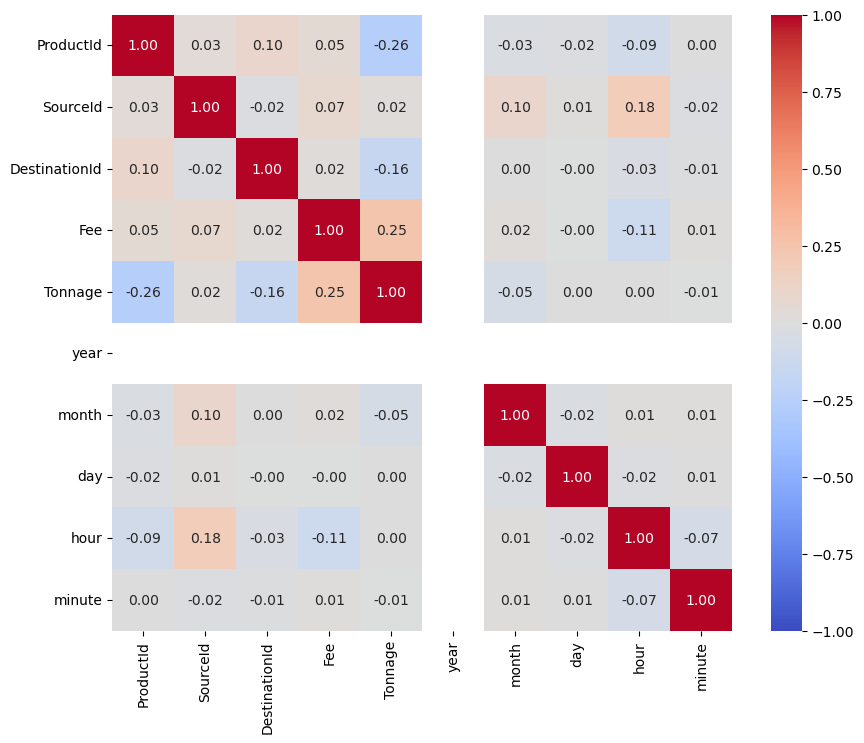

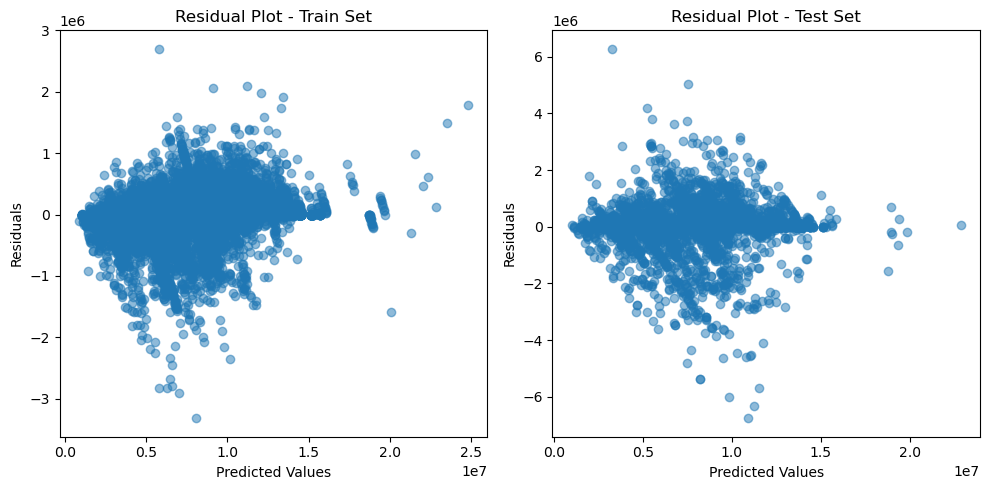

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plot_residuals(best_model,  X_train, X_test, y_train, y_test)


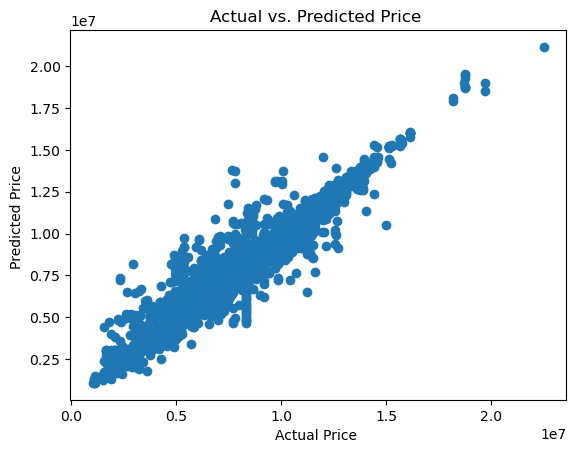

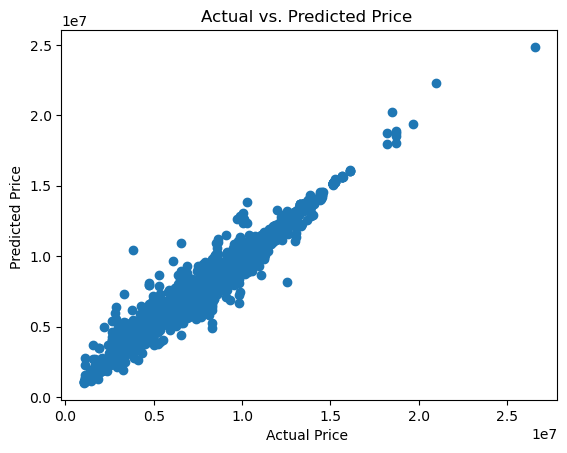

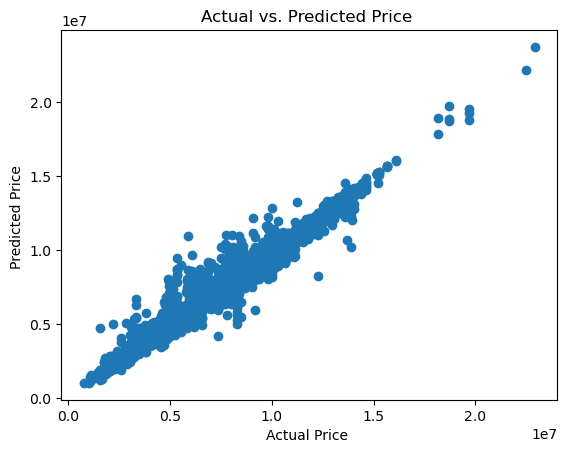

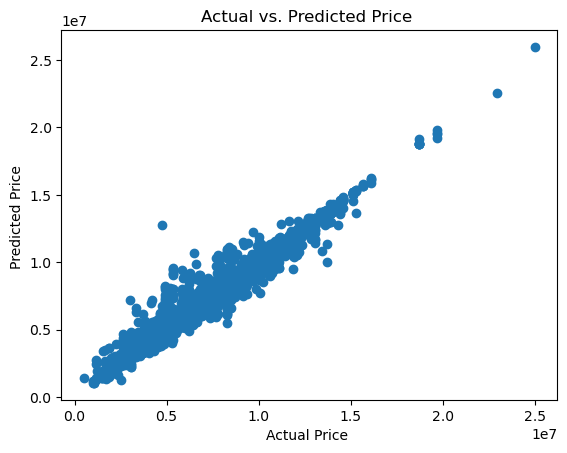

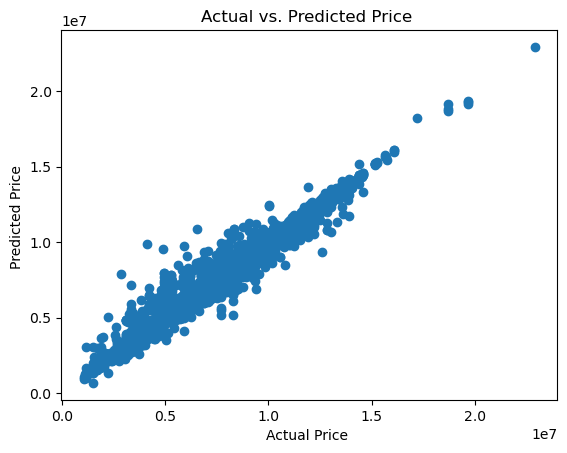

In [17]:
for X_train, X_test, y_train, y_test in split_data(df):
    # Fit the model on the training data
    best_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = best_model.predict(X_test)
    
    # Plot the actual vs. predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Price ')
    plt.ylabel('Predicted Price ')
    plt.title('Actual vs. Predicted Price ')
    plt.show()